# Plot some example Flux Curves
(notice that some are missing points)

51470


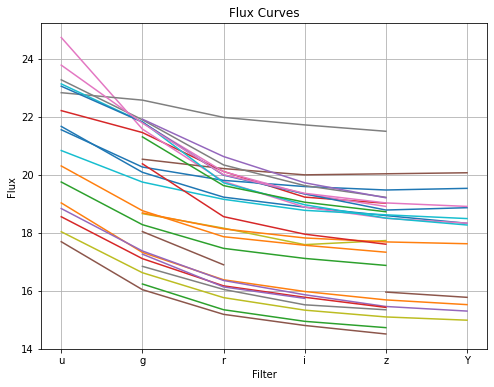

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Load the data from CSV
data = pd.read_csv('data/specz_fluxes.csv')

print(len(data))

random_rows = data.sample(n=28)

column_names = ['u_cmodel_mag', 
                'g_cmodel_mag', 
                'r_cmodel_mag',
                'i_cmodel_mag',
                'z_cmodel_mag',
                'Y_cmodel_mag',]

# Extract specific columns (2nd, 4th, 6th, 8th, 10th, 12th) from the random rows
selected_elements = random_rows.loc[:, column_names].values

# Plot the random x values
plt.figure(figsize=(8, 6))

for element in selected_elements:
    plt.plot(range(len(column_names)), element)
    plt.xlabel('Filter')
    plt.ylabel('Flux')
    
plt.xticks(range(len(column_names)),['u','g','r','i','z','Y'])
plt.title(f'Flux Curves')
plt.grid(True)
plt.show()

# Cleaning (Generate Full Flux Curces)

In [8]:
import pandas as pd
from tqdm import tqdm

# Load the data from CSV
data = pd.read_csv('data/specz_fluxes.csv')

# Replace inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna(subset=['res'])

filters = ['u_cmodel_mag', 'g_cmodel_mag','r_cmodel_mag', 'i_cmodel_mag','z_cmodel_mag', 'Y_cmodel_mag']
ferrors = ['u_cmodel_magerr', 'g_cmodel_magerr','r_cmodel_magerr', 'i_cmodel_magerr','z_cmodel_magerr', 'Y_cmodel_magerr']

# Calculate the average difference between adjacent filter
avg_difference = []
for i in range(5):
    data_temp = data.dropna(subset=[filters[i], filters[i+1]])
    difference = data_temp[filters[i]] - data_temp[filters[i+1]]
    avg_dif = np.average(difference)
    print(f"The average difference {filters[i]} - {filters[i+1]} is: {avg_dif}")
    avg_difference.append(avg_dif)
    
# Calculate the average percent error of the error
avg_ratio = []
for i in range(6):
    data_temp = data.dropna(subset=[filters[i], ferrors[i]])
    ratio = data_temp[filters[i]+'err'] / data_temp[filters[i]]
    avg_rat = np.average(ratio)
    #print(f"The average ratio {filters[i]+'err'} / {filters[i]} is: {avg_rat}")
    avg_ratio.append(avg_dif)
    
# Iterate through each row and fill in missing fluxes
for index, row in tqdm(data.iterrows(), total=len(data), desc='filling empty mag'):        
    # Subset the row to the specified columns
    selected_row = row[filters]

    if np.sum(np.isnan(selected_row)) == 0:
        continue # skip if data is complete
        
    # build from left
    left_build = np.copy(selected_row)
    for i in [1,2,3,4,5]:
        if not np.isnan(left_build[i-1]) and np.isnan(left_build[i]):
            left_build[i] = left_build[i-1] - avg_difference[i-1]
    
    # build from right
    right_build = np.copy(selected_row)
    for i in [4,3,2,1,0]:
        if not np.isnan(right_build[i+1]) and np.isnan(right_build[i]):
            right_build[i] = right_build[i+1] + avg_difference[i]
    
    left_build[np.isnan(left_build)] = right_build[np.isnan(left_build)]
    right_build[np.isnan(right_build)] = left_build[np.isnan(right_build)]
    full_build = (left_build + right_build) / 2
    
    # fill in gaps and then average
    left_build[np.isnan(left_build)] = right_build[np.isnan(left_build)]
    right_build[np.isnan(right_build)] = left_build[np.isnan(right_build)]
    full_build = (left_build + right_build) / 2
    
    row[filters] = full_build
    
    
# Iterate through each row and fill in missing flux errors
for index, row in tqdm(data.iterrows(), total=len(data), desc='filling empty magerr'):        
    # Subset the row to the specified columns
    values = row[filters]
    errors = row[ferrors]
    
    if np.sum(np.isnan(errors)) == 0:
        continue # skip if data is complete
        
    # fill
    full_error = np.copy(errors)
    for i in range(6):
        if np.isnan(full_error[i]):
            full_error[i] = values[i] * avg_ratio[i]
    
    row[ferrors] = full_error
    
    
data.to_csv('data/clean_specz_fluxes.csv', index=False)  # This will save the DataFrame to 'filename.csv' without writing row indices


The average difference u_cmodel_mag - g_cmodel_mag is: 1.4074439403551409
The average difference g_cmodel_mag - r_cmodel_mag is: 1.063740699150348
The average difference r_cmodel_mag - i_cmodel_mag is: 0.4724828275390897
The average difference i_cmodel_mag - z_cmodel_mag is: 0.2852583794721852
The average difference z_cmodel_mag - Y_cmodel_mag is: 0.1341760480424204


filling empty magerr: 100%|█████████████| 51295/51295 [00:28<00:00, 1817.48it/s]


# Plot some Flux Curves
(Notice they are now complete)

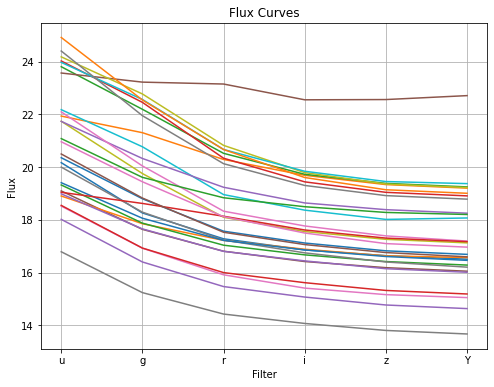

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Load the data from CSV
data = pd.read_csv('data/clean_specz_fluxes.csv')

random_rows = data.sample(n=28)

column_names = ['u_cmodel_mag', 
                'g_cmodel_mag', 
                'r_cmodel_mag',
                'i_cmodel_mag',
                'z_cmodel_mag',
                'Y_cmodel_mag',]

# Extract specific columns (2nd, 4th, 6th, 8th, 10th, 12th) from the random rows
selected_elements = random_rows.loc[:, column_names].values

# Plot the random x values
plt.figure(figsize=(8, 6))

for element in selected_elements:
    plt.plot(range(len(column_names)), element)
    plt.xlabel('Filter')
    plt.ylabel('Flux')
    
plt.xticks(range(len(column_names)),['u','g','r','i','z','Y'])
plt.title(f'Flux Curves')
plt.grid(True)
plt.show()

# Example FCNN

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the data from CSV
data = pd.read_csv('data/clean_specz_fluxes.csv')

print('Length of data', len(data))

column_names = ['res',
                'g_cmodel_mag', 
                'r_cmodel_mag',
                'i_cmodel_mag',
                'z_cmodel_mag',]

# Extract features (inputs) and labels
X = data.loc[:, column_names].values  # Features from 2nd, 4th, 6th, 8th, 10th, and 12th columns
y = data['spec_z'].values.reshape(-1, 1)     # Labels

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define a custom dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Define the data loaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

def choose_two(x):
    return x * (x - 1) // 2

lay1_num = 32
lay2_num = lay1_num//2

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(len(column_names), lay1_num)
        self.fc2 = nn.Linear(lay1_num, lay2_num)
        self.fc3 = nn.Linear(lay2_num, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = NeuralNetwork()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_dataset)
    print(f"Epoch [{epoch+1:02d}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")


# Testing loop
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_dataset)
print(f"\nTest Loss: {test_loss:.4f}")


Length of data 51295
Epoch [01/20], Training Loss: 0.3464, Validation Loss: 0.0472
Epoch [02/20], Training Loss: 0.0505, Validation Loss: 0.0353
Epoch [03/20], Training Loss: 0.0407, Validation Loss: 0.0308
Epoch [04/20], Training Loss: 0.0371, Validation Loss: 0.0276
Epoch [05/20], Training Loss: 0.0358, Validation Loss: 0.0268
Epoch [06/20], Training Loss: 0.0350, Validation Loss: 0.0262
Epoch [07/20], Training Loss: 0.0346, Validation Loss: 0.0261
Epoch [08/20], Training Loss: 0.0341, Validation Loss: 0.0259
Epoch [09/20], Training Loss: 0.0337, Validation Loss: 0.0252
Epoch [10/20], Training Loss: 0.0334, Validation Loss: 0.0276
Epoch [11/20], Training Loss: 0.0329, Validation Loss: 0.0246
Epoch [12/20], Training Loss: 0.0326, Validation Loss: 0.0245
Epoch [13/20], Training Loss: 0.0323, Validation Loss: 0.0244
Epoch [14/20], Training Loss: 0.0320, Validation Loss: 0.0238
Epoch [15/20], Training Loss: 0.0317, Validation Loss: 0.0334
Epoch [16/20], Training Loss: 0.0315, Validation 

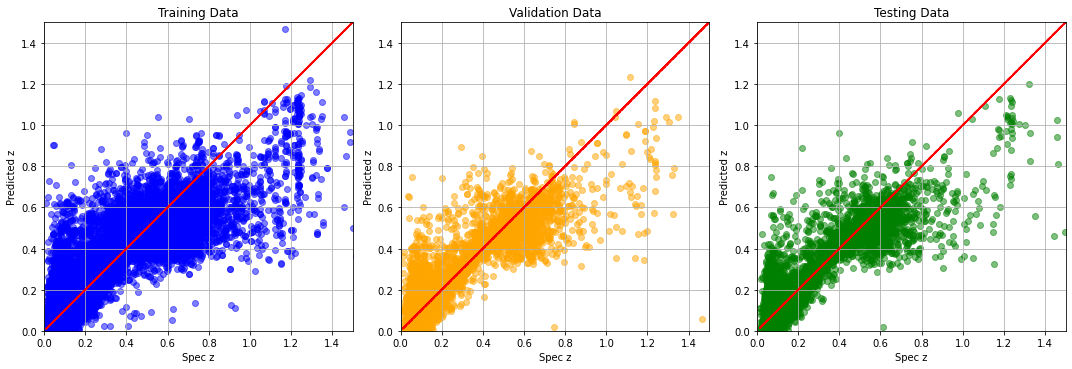

In [7]:
import matplotlib.pyplot as plt

# Function to plot predicted labels versus true labels
def plot_predictions(model, data_loaders, titles):
    model.eval()
    plt.figure(figsize=(15, 5))
    
    for i, loader in enumerate(data_loaders):
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                predicted_labels.extend(outputs.numpy())
                true_labels.extend(labels.numpy())
        
        if i == 0:
            color = 'blue'  # Set color to blue for training
        elif i == 1:
            color = 'orange'  # Set color to orange for validation
        else:
            color = 'green'  # Set color to green for testing
            
        plt.subplot(1, len(data_loaders), i + 1)
        plt.scatter(true_labels, predicted_labels, color=color, alpha=0.5)
        plt.plot(true_labels, true_labels, color='red', linestyle='--')
        plt.xlabel('Spec z')
        plt.ylabel('Predicted z')
        plt.title(titles[i])
        plt.grid(True)
        plt.xlim(0, 1.5)
        plt.ylim(0, 1.5)
        plt.gca().set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Define data loaders and titles
data_loaders = [train_loader, val_loader, test_loader]
titles = ['Training Data', 'Validation Data', 'Testing Data']

# Plot predicted labels versus true labels for each data loader
plot_predictions(model, data_loaders, titles)
